# Population Estimation Notebook
- Notebook for creation of population estimates for years between US official census.
- ETL Script: ```db_estimate_script.py```

In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

from config import DATABASE_URI
from models import NameEntry, StateEntry

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import us

## Extract Data From PostgreSQL Database
- Data: [Wikipedia](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_historical_population)
- Scraping script: ```db_population_script.py```

In [2]:
# Create PostgreSQL database connection with SQLAlchemy
engine = create_engine(DATABASE_URI)
Session = sessionmaker(bind=engine)

In [3]:
# Get data from database
s = Session()
q = s.query(StateEntry.state, StateEntry.year, StateEntry.population).all()
s.close()

# Convert to DataFrame
pops = [ {'state': v[0], 'year': v[1], 'population': v[2]} for v in q ]
pops = pd.DataFrame(pops)

In [4]:
# Sample
pops.head(3)

,state,year,population
0,Alabama,1960,3266740
1,Alabama,1970,3444165
2,Alabama,1980,3893888


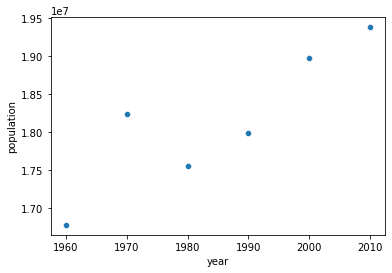

In [17]:
# Sample
sns.scatterplot(data=pops.loc[pops['state'] == 'New York'], x='year', y='population')
plt.show()

## Estimate Population from Data
- Create function to estimate state populations for years in between census years.
- Estimates are derived from a simple linear population slope.

In [5]:
def get_pop_est(state):
    '''
    Function to create population estimates between census years
    '''
    
    years_ = range(1960, 2010)
    ps = np.array(pops.loc[pops['state'] == state]['population'])
    
    # Population slope between census data years
    ms = np.diff(ps) / 10
    
    # Initial population of decade
    cs = ps[:-1]
    
    # Create estimates through matrix operations
    ests = np.round((np.arange(0, 10).reshape(-1, 1) * ms + np.ones(10).reshape(-1,1) * cs)).T
    
    ests = [
        {'state': state, 'year': year, 'population': int(est)}
        for year, est in zip(years_, ests.flatten())
    ]
    
    return ests

In [6]:
# Sample
get_pop_est('New York')[:5]

[{'state': 'New York', 'year': 1960, 'population': 16782304},
 {'state': 'New York', 'year': 1961, 'population': 16927770},
 {'state': 'New York', 'year': 1962, 'population': 17073237},
 {'state': 'New York', 'year': 1963, 'population': 17218703},
 {'state': 'New York', 'year': 1964, 'population': 17364169}]

## Extract and Clean Data
- Data from: [US Census Bureau - State Populations + DC (2010-2019)](https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html)

In [7]:
# Set states
states = [ f'{state.name}' for state in us.states.STATES ] + ['District of Columbia']

In [8]:
# Load excel file
tens = pd.read_excel('data/nst-est2019-01.xlsx', index_col=0) # Note: years in 3rd row
tens.head(3)

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),,,,,,,,,,,,
"Table 1. Annual Estimates of the Resident Population for the United States, Regions, States, and Puerto Rico: April 1, 2010 to July 1, 2019",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Geographic Area,2010-04-01 00:00:00,NaN,Population Estimate (as of July 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0


In [9]:
# Select rows with states or DC (Example: '.Alabama')
tens = tens.loc[[ '.' + state for state in states ]]
tens.index.name = 'state'

# Select columns with yearly population data and rename columns
tens = tens[[ f'Unnamed: {i}' for i in range(3, 13) ]]
tens.columns = range(2010, 2020)

# Reset index and clean state names
tens.reset_index(inplace=True)
tens['state'] = [ state[1:] for state in tens['state'] ]

In [10]:
# Sample
tens.head(3)

,state,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Alabama,4785437,4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0
1,Alaska,713910,722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0
2,Arizona,6407172,6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0


In [11]:
# Make DataFrame wide to long
df = tens.melt(id_vars='state', value_vars=range(2010, 2020), var_name='year', value_name='population')

In [12]:
# Sample
df.head(3)

,state,year,population
0,Alabama,2010,4785437
1,Alaska,2010,713910
2,Arizona,2010,6407172


In [13]:
# Concat estimates onto US Census Bureau data
for state in states:
    df = pd.concat([df, pd.DataFrame(get_pop_est(state))], ignore_index=True)

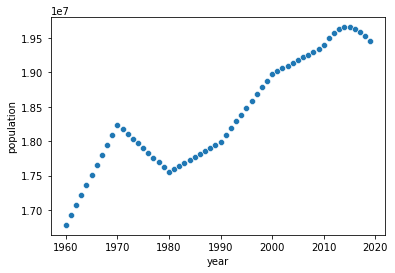

In [14]:
# Sample
sns.scatterplot(data=df.loc[df['state'] == 'New York'], x='year', y='population')
plt.show()